In [2]:
import vaex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.mixture import GaussianMixture

In [7]:
df_trips = vaex.open('data/trips/trips_prepared.hdf5')

# for testing with reduced lines
df_trips = df_trips.sample(n=100000, random_state=42)

In [3]:
df_trips.info()

column,type,unit,description,expression
Taxi ID_encoded,int64,,,
Company,str,,,
Company_encoded,int64,,,
ts_start,datetime64[us],,,
ts_end,datetime64[us],,,
start_day,datetime64[us],,,
start_weekday,int32,,,
start_month,int32,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,


In [4]:
trip_attributes          = ['start_month', 'start_weekday', 'start_1_hour', 'Trip Seconds', 'Trip Total']
trip_clustering_features = ['start_month', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour_sin','start_1_hour_cos', 'Trip Seconds', 'Trip Total']

trip_clustering_df          = df_trips[trip_attributes].to_pandas_df()
trip_clustering_unscaled_df = df_trips[trip_clustering_features].to_pandas_df()

In [5]:
trip_clustering_df

,start_month,start_weekday,start_1_hour,Trip Seconds,Trip Total
0,1,1,8,840.0,9.75
1,2,5,22,1108.0,15.25
2,11,4,23,600.0,10.65
3,3,6,11,0.0,3.25
4,3,4,22,360.0,7.55
...,...,...,...,...,...
99995,8,1,17,591.0,9.85
99996,3,2,18,360.0,6.05
99997,8,2,11,320.0,6.65
99998,1,3,11,627.0,9.65


https://www.kaggle.com/code/emilytries/clustering-and-feature-selection/notebook

In [6]:
trip_clustering_df.fillna(0, inplace=True)
trip_clustering_unscaled_df.fillna(0, inplace=True)

In [37]:
def outlier_thresholds(dataframe, variable):
    lower_quantile = dataframe[variable].quantile(0.025)
    upper_quantile = dataframe[variable].quantile(0.975)
    interquantile_range = upper_quantile - lower_quantile
    up_limit  = upper_quantile + 1.5 * interquantile_range
    low_limit = lower_quantile - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def remove_all_outliers(dataframe):
    for col in dataframe.columns:
        replace_with_thresholds(dataframe, col)

In [38]:
remove_all_outliers(trip_clustering_df)
remove_all_outliers(trip_clustering_unscaled_df)

In [8]:
trip_clustering_unscaled_df

,start_month,start_weekday_sin,start_weekday_cos,start_1_hour_sin,start_1_hour_cos,Trip Seconds,Trip Total
0,1.0,0.781831,0.623490,0.866025,-5.000000e-01,840.0,9.75
1,2.0,-0.974928,-0.222521,-0.500000,8.660254e-01,1108.0,15.25
2,11.0,-0.433884,-0.900969,-0.258819,9.659258e-01,600.0,10.65
3,3.0,-0.781831,0.623490,0.258819,-9.659258e-01,0.0,3.25
4,3.0,-0.433884,-0.900969,-0.500000,8.660254e-01,360.0,7.55
...,...,...,...,...,...,...,...
99995,8.0,0.781831,0.623490,-0.965926,-2.588190e-01,591.0,9.85
99996,3.0,0.974928,-0.222521,-1.000000,-1.836970e-16,360.0,6.05
99997,8.0,0.974928,-0.222521,0.258819,-9.659258e-01,320.0,6.65
99998,1.0,0.433884,-0.900969,0.258819,-9.659258e-01,627.0,9.65


Check for missing values

In [9]:
trip_clustering_unscaled_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   start_month        100000 non-null  float64
 1   start_weekday_sin  100000 non-null  float64
 2   start_weekday_cos  100000 non-null  float64
 3   start_1_hour_sin   100000 non-null  float64
 4   start_1_hour_cos   100000 non-null  float64
 5   Trip Seconds       100000 non-null  float64
 6   Trip Total         100000 non-null  float64
dtypes: float64(7)
memory usage: 5.3 MB


In [40]:
def plt_corr(dataframe):
    base_df_corr = dataframe.corr()
    mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figwidth(20)
    sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
    plt.show()

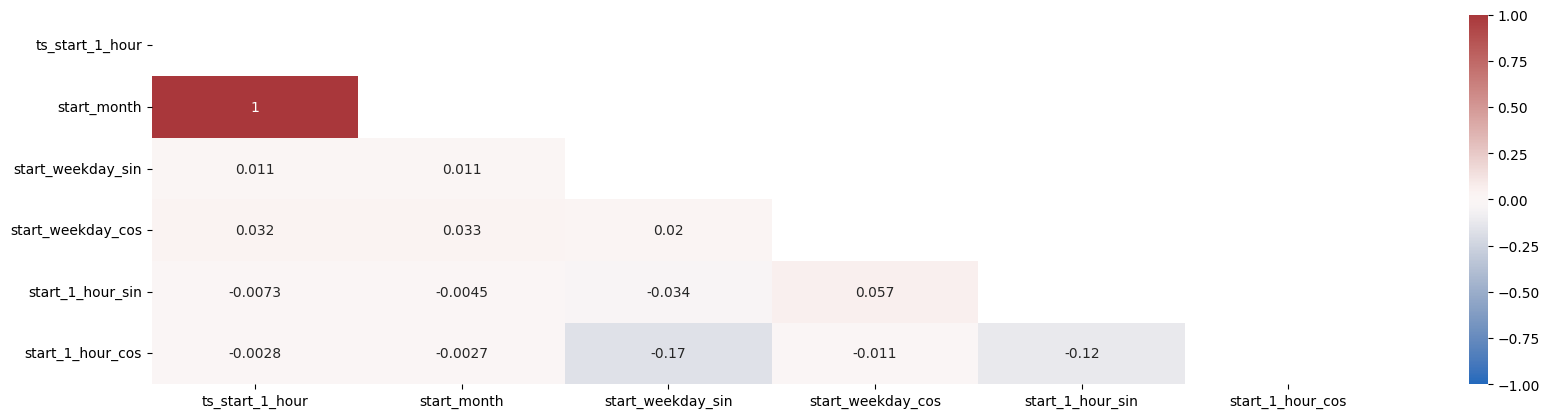

In [41]:
plt_corr(trip_clustering_unscaled_df)

In [42]:
def scale_df(dataframe):
    scaler = StandardScaler()
    scaler.fit(dataframe)
    dataframe_scaled = scaler.transform(dataframe)

    scaled_df = pd.DataFrame(dataframe_scaled, columns = dataframe.columns, index = dataframe.index)

    return scaled_df

In [12]:
trip_clustering_scaled_df = scale_df(trip_clustering_unscaled_df)

,start_month,start_weekday_sin,start_weekday_cos,start_1_hour_sin,start_1_hour_cos,Trip Seconds,Trip Total
0,1.0,0.781831,0.623490,0.866025,-5.000000e-01,840.0,9.75
1,2.0,-0.974928,-0.222521,-0.500000,8.660254e-01,1108.0,15.25
2,11.0,-0.433884,-0.900969,-0.258819,9.659258e-01,600.0,10.65
3,3.0,-0.781831,0.623490,0.258819,-9.659258e-01,0.0,3.25
4,3.0,-0.433884,-0.900969,-0.500000,8.660254e-01,360.0,7.55
...,...,...,...,...,...,...,...
99995,8.0,0.781831,0.623490,-0.965926,-2.588190e-01,591.0,9.85
99996,3.0,0.974928,-0.222521,-1.000000,-1.836970e-16,360.0,6.05
99997,8.0,0.974928,-0.222521,0.258819,-9.659258e-01,320.0,6.65
99998,1.0,0.433884,-0.900969,0.258819,-9.659258e-01,627.0,9.65


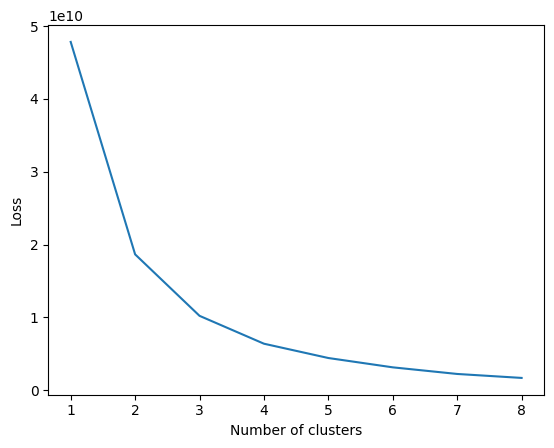

In [13]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
    model.fit(trip_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [14]:
trip_model_k_means = KMeans(n_clusters = 3, n_init=10, init="k-means++", random_state=42)
trip_model_k_means.fit(trip_clustering_scaled_df)

trip_clustering_df['cluster_k_means'] = trip_model_k_means.predict(trip_clustering_scaled_df)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans

In [15]:
trip_model_bisecting_k_means = BisectingKMeans(n_clusters = 3, init="k-means++", random_state=42)
trip_model_bisecting_k_means.fit(trip_clustering_scaled_df)
trip_clustering_df['cluster_bisecting_k_means'] = trip_model_k_means.predict(trip_clustering_scaled_df)

trip_model_bisecting_k_means.cluster_centers_

array([[ 6.69091935e+00, -1.79827777e-03, -4.48145075e-02,
        -2.33783097e-01, -1.65831692e-01,  1.69651358e+03,
         3.15432024e+01],
       [ 6.91012114e+00,  1.50552697e-01, -1.36649102e-01,
        -3.48431872e-01, -3.59684750e-01,  3.48210903e+03,
         4.59071493e+01],
       [ 6.64844173e+00, -5.67271930e-02, -5.91162303e-02,
        -2.24347060e-01, -1.54285316e-02,  4.88729084e+02,
         1.01233221e+01]])

In [16]:
# soft clustering with gaussian mixture model
gmm_trips = GaussianMixture(n_components = 3, random_state = 42)
gmm_trips.fit(trip_clustering_scaled_df)

# retrieve assigned cluster labels
trip_clustering_df['cluster_gmm'] = gmm_trips.predict(trip_clustering_scaled_df)

# check convergence
print(gmm_trips.converged_)

True


In [17]:
trip_clustering_df

,start_month,start_weekday,start_1_hour,Trip Seconds,Trip Total,cluster_k_means,cluster_bisecting_k_means,cluster_gmm
0,1.0,1,8.0,840.0,9.75,2,2,1
1,2.0,5,22.0,1108.0,15.25,2,2,0
2,11.0,4,23.0,600.0,10.65,1,1,1
3,3.0,6,11.0,0.0,3.25,1,1,1
4,3.0,4,22.0,360.0,7.55,1,1,1
...,...,...,...,...,...,...,...,...
99995,8.0,1,17.0,591.0,9.85,1,1,1
99996,3.0,2,18.0,360.0,6.05,1,1,1
99997,8.0,2,11.0,320.0,6.65,1,1,1
99998,1.0,3,11.0,627.0,9.65,1,1,1


In [43]:
 def plt_violins(dataframe):
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [ ]:
plt_violins(trip_clustering_df)

## Weather/trip clustering

In [96]:
weather_df = pd.read_pickle("data/weather.pickle")
weather_df

,Temperature,Humidity,Wind Speed,Precip.,cloud,rain,Fair,Fog,Snow,T-Storm,Thunder
datetime,,,,,,,,,,,
2014-01-01 00:00:00,-10.0,84.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,-8.9,84.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 02:00:00,-8.3,84.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 03:00:00,-7.8,84.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 04:00:00,-7.2,85.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,-7.2,47.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2014-12-31 20:00:00,-7.2,50.0,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2014-12-31 21:00:00,-6.7,48.0,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [97]:
#weather_attributes = ['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain', 'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder']
weather_attributes = ['Temperature', 'Precip.', 'cloud']

weather_df = weather_df[weather_attributes]

In [98]:
df_trips = vaex.open('data/trips/trips_prepared.hdf5')

# for testing with reduced lines
df_trips = df_trips.sample(n=100000, random_state=42)

In [127]:
trip_attributes          = ['ts_start_1_hour', 'start_month', 'start_weekday', 'start_1_hour']
trip_clustering_features = ['ts_start_1_hour']#, 'start_month', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour_sin','start_1_hour_cos']

trip_clustering_df          = df_trips[trip_attributes].to_pandas_df()
trip_clustering_unscaled_df = df_trips[trip_clustering_features].to_pandas_df()

Join trips and weather

In [128]:
trip_weather_clustering_df = trip_clustering_df.merge(weather_df, left_on='ts_start_1_hour', right_on='datetime', how='left')
trip_weather_clustering_unscaled_df = trip_clustering_unscaled_df.merge(weather_df, left_on='ts_start_1_hour', right_on='datetime', how='left')

trip_weather_clustering_df.drop(columns=['ts_start_1_hour'], inplace=True)
trip_weather_clustering_unscaled_df.drop(columns=['ts_start_1_hour'], inplace=True)


In [129]:
trip_weather_clustering_unscaled_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperature  100000 non-null  float64
 1   Precip.      100000 non-null  float64
 2   cloud        100000 non-null  float64
dtypes: float64(3)
memory usage: 2.3 MB


In [130]:
# scaling trip_df with the go-to scaling in industry
scaler = StandardScaler()
scaler.fit(trip_weather_clustering_unscaled_df)
trip_weather_clustering_scaled = scaler.transform(trip_weather_clustering_unscaled_df)

trip_weather_clustering_scaled_df = pd.DataFrame(trip_weather_clustering_scaled, columns = trip_weather_clustering_unscaled_df.columns, index = trip_weather_clustering_unscaled_df.index)

In [131]:
trip_weather_clustering_scaled_df

,Temperature,Precip.,cloud
0,-2.255735,-0.098735,-1.311247
1,-1.199157,-0.098735,1.136327
2,-1.199157,-0.098735,0.320469
3,-1.389010,-0.098735,0.320469
4,-0.192105,-0.098735,1.136327
...,...,...,...
99995,1.458799,-0.098735,-0.495389
99996,-0.654358,-0.098735,0.320469
99997,1.227672,-0.098735,0.320469
99998,-1.017557,-0.098735,1.136327


## Correlation analysis of weather_df

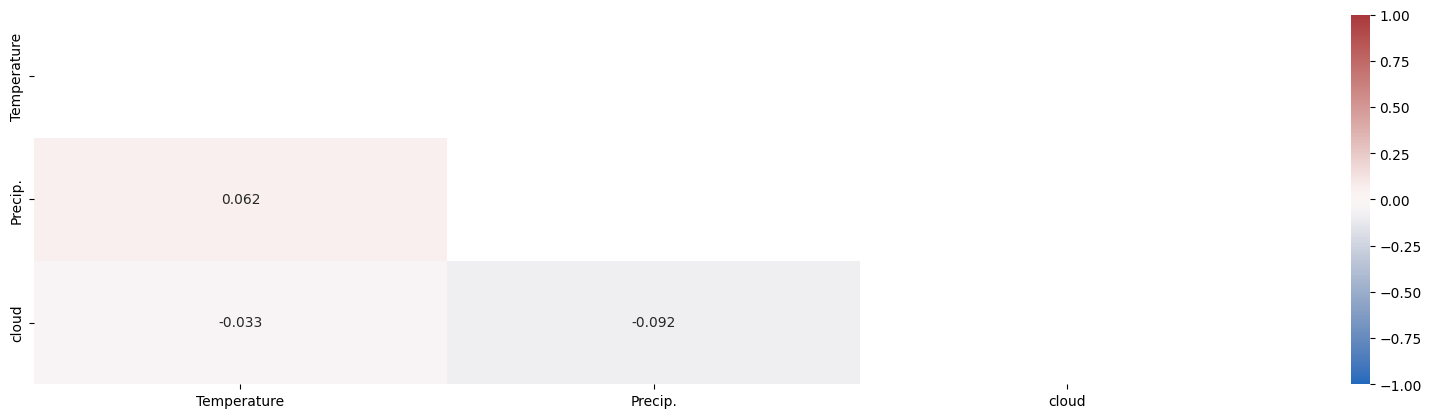

In [132]:
plt_corr(trip_weather_clustering_scaled_df)

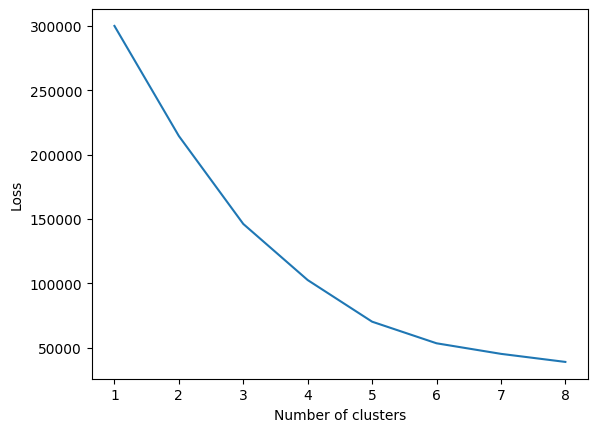

In [133]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
    model.fit(trip_weather_clustering_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [134]:
trip_weather_model_k_means = KMeans(n_clusters = 3, n_init=10, init="k-means++", random_state=42)
trip_weather_model_k_means.fit(trip_weather_clustering_scaled_df)

trip_weather_clustering_df['cluster_k_means'] = trip_weather_model_k_means.predict(trip_weather_clustering_scaled_df)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans

In [135]:
trip_weather_model_bisecting_k_means = BisectingKMeans(n_clusters = 3, init="k-means++", random_state=42)
trip_weather_model_bisecting_k_means.fit(trip_weather_clustering_scaled_df)
trip_weather_clustering_df['cluster_bisecting_k_means'] = trip_weather_model_bisecting_k_means.predict(trip_weather_clustering_scaled_df)

trip_weather_model_bisecting_k_means.cluster_centers_

array([[-9.17518501e-01, -8.79446834e-02,  2.36068129e-01],
       [ 7.61949491e-01, -4.86318893e-03, -1.92249273e-01],
       [ 8.60533725e-01,  1.61197180e+01, -1.00221015e+00]])

In [136]:
# soft clustering with gaussian mixture model
gmm_trips = GaussianMixture(n_components = 3, random_state = 42)
gmm_trips.fit(trip_weather_clustering_scaled_df)

# retrieve assigned cluster labels
trip_weather_clustering_df['cluster_gmm'] = gmm_trips.predict(trip_weather_clustering_scaled_df)

# check convergence
print(gmm_trips.converged_)

True


In [137]:
trip_weather_clustering_df

,start_month,start_weekday,start_1_hour,Temperature,Precip.,cloud,cluster_k_means,cluster_bisecting_k_means,cluster_gmm
0,1,1,8,-16.1,0.0,0.0,1,0,0
1,2,5,22,-3.3,0.0,3.0,0,0,0
2,11,4,23,-3.3,0.0,2.0,0,0,0
3,3,6,11,-5.6,0.0,2.0,0,0,0
4,3,4,22,8.9,0.0,3.0,0,0,0
...,...,...,...,...,...,...,...,...,...
99995,8,1,17,28.9,0.0,1.0,1,1,1
99996,3,2,18,3.3,0.0,2.0,0,0,0
99997,8,2,11,26.1,0.0,2.0,0,1,1
99998,1,3,11,-1.1,0.0,3.0,0,0,0


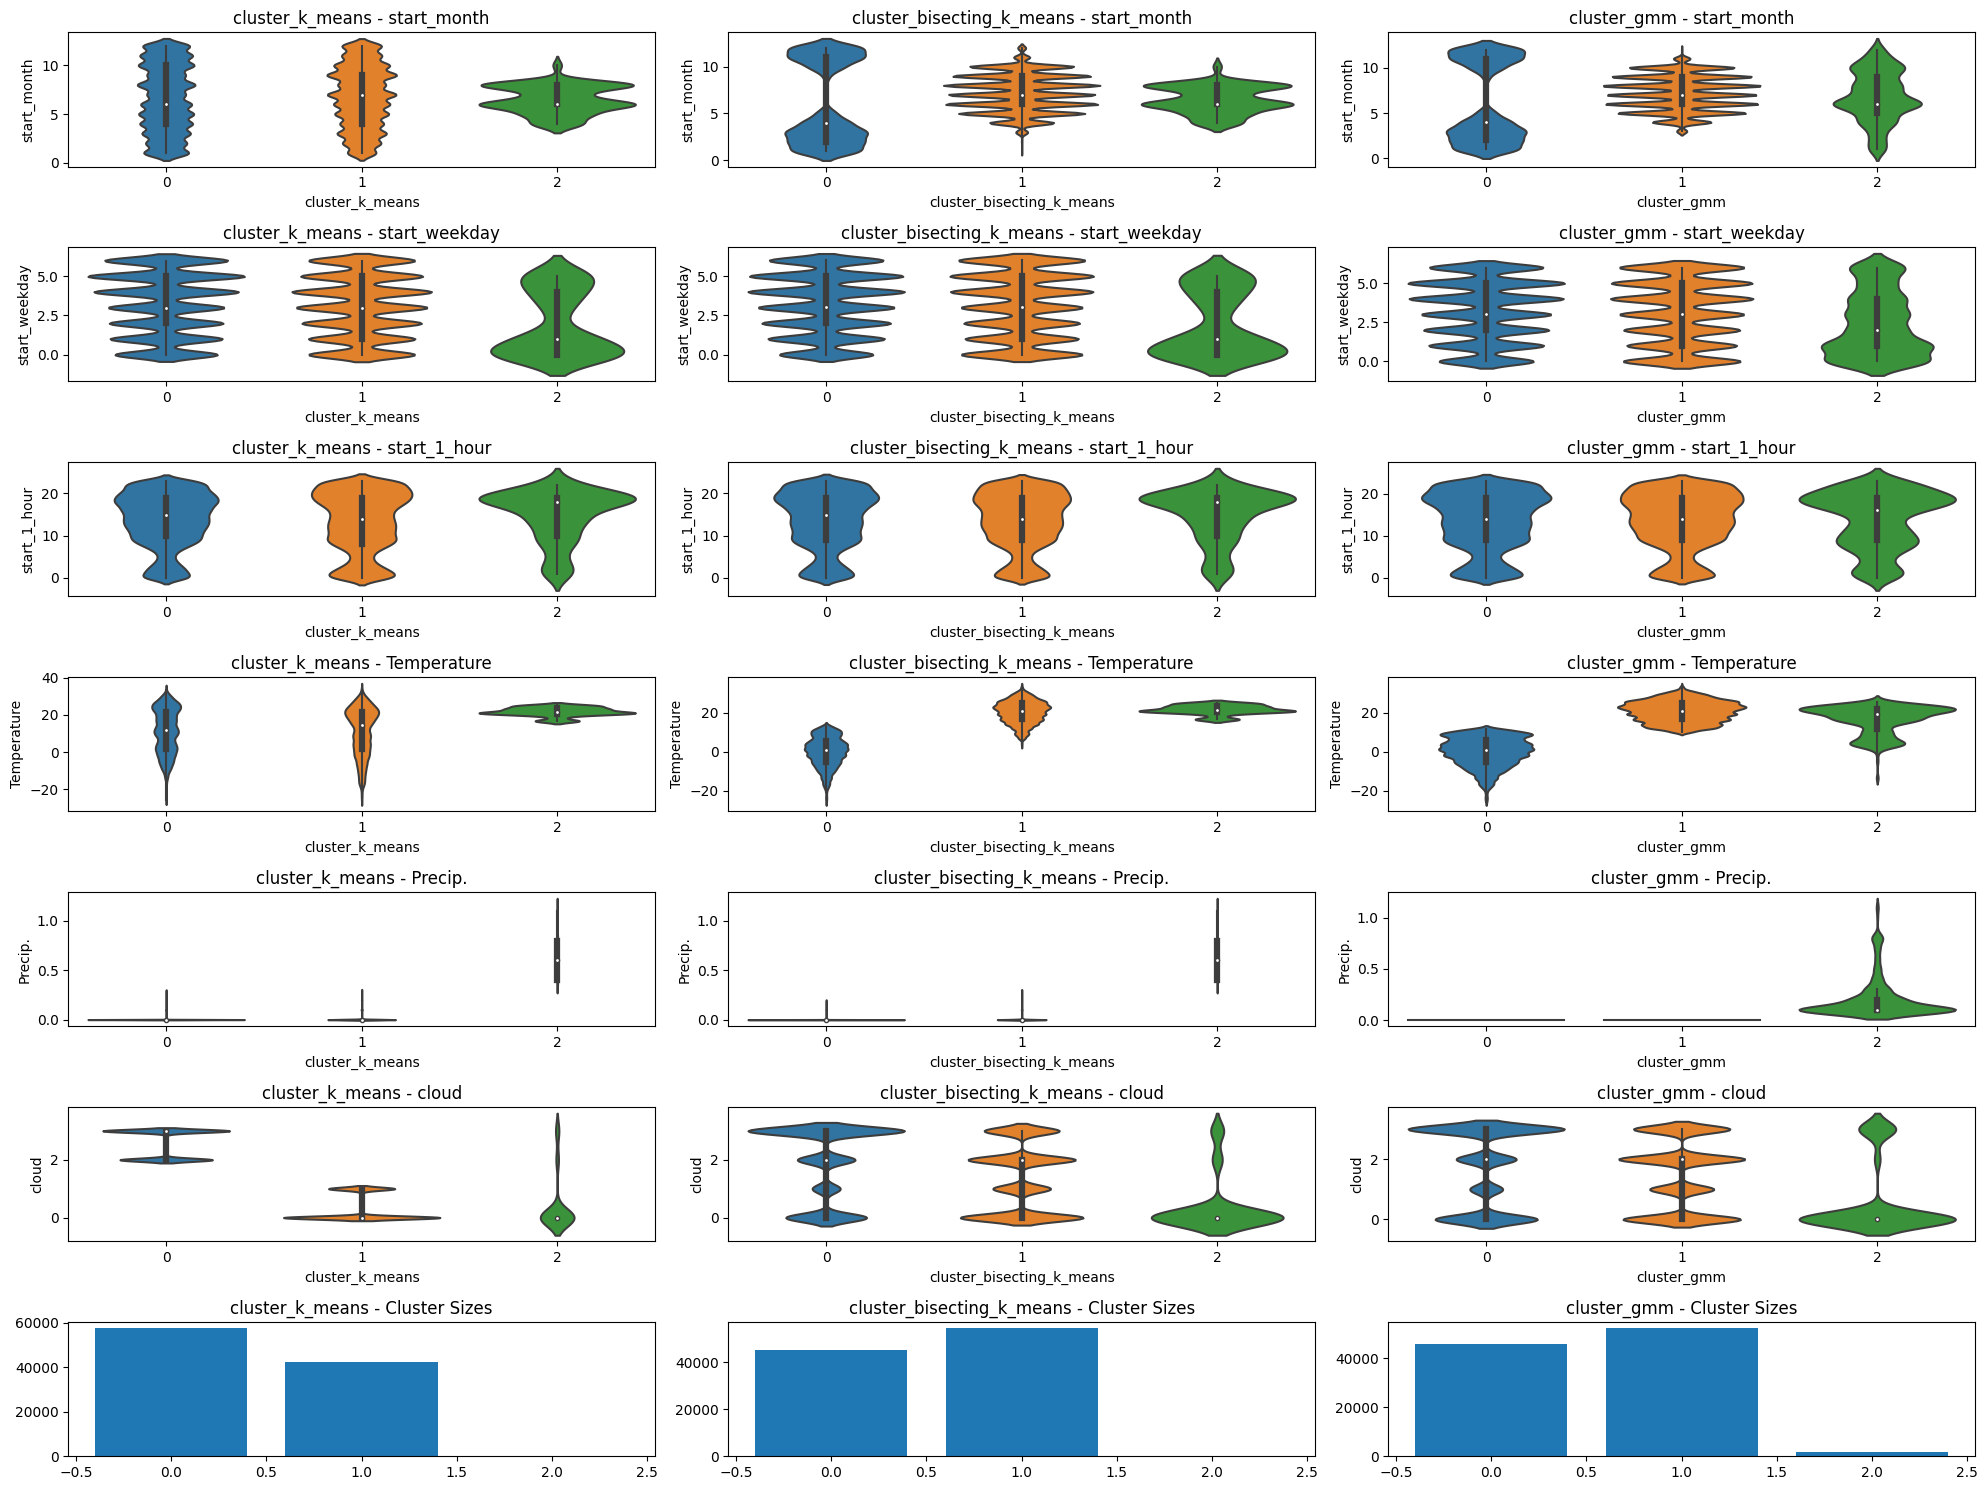

In [138]:
plt_violins(trip_weather_clustering_df)